# Theory

So far we worked with tabular data. Today we try something different, i.e.,  *image classification*. As a task, we aim to predict *digits* provided by the *MNIST* dataset, a popular dataset used in Machine Learning to test new algorithms.

We will now import it and see how such digits look like (after having loaded all relevant libraries).

In [ ]:
# SETUP
# install python 3.10
!apt-get install python3.10

# update symbolic links to the newly installed python version
!ln -sf /usr/bin/python3.10 /usr/bin/python
!ln -sf /usr/bin/python3.10 /usr/bin/python3

# install numpy 1.23.5
%pip install numpy==1.23.5
# install scikit-learn 1.2.2
%pip install scikit-learn==1.2.2
# install keras 2.13.1
%pip install keras==2.13.1
# install tensorflow 2.13.0
%pip install tensorflow==2.13.0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10 is already the newest version (3.10.12-1~22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
# import libraries
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

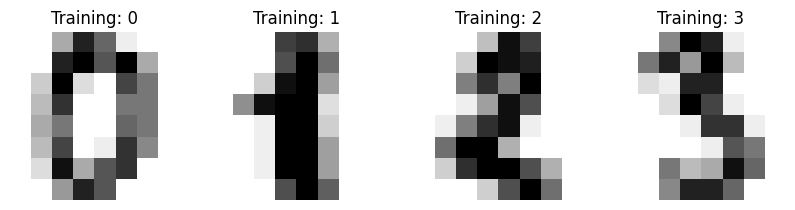

In [ ]:
# load dataset
digits = datasets.load_digits()

# visualize dataset
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [ ]:
# Split data into 80% train+validation and 20% test subsets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    digits.data, digits.target, test_size=0.2, shuffle=False
)

# Split the train+validation into 80% train and 20% validation subsets
# validation for set the hyperparameter in the SVM
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, shuffle=False
)

len(X_train), len(X_val), len(X_test)

(1149, 288, 360)

We can visualize one example --- how a data sample looks like.

In [ ]:
X_train[0].shape

(64,)

In [ ]:
# vector X_train
X_train[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

It's a 1-dimensional array containing 64 integers, each representing the grey value of the corresponding pixel (the images were originally 8x8 pixels, but they have been flattened into a 1-dimensional array to use them more easily with the ML algorithms in Sklearn).
We can now begin to train a Support Vector Machine for classifying the digits.
We use a *polynomial kernel*: $K_{poly}(x_1, x_2) = (x_1^T x_2+e)^d$, where $d$ and $e$ are named *degree* and *coef0* in Sklearn, respectively. The parameter $e$ usually take the values {0,1}, while $d\geq 1$ indicates that we are considering d-tuples of the input elements. d = combination of feature (dot product).

When $d=1, e=0$ we get a special case called *linear kernel* (the $\phi()$ corresponding to the linear kernel is $\phi(x)→x$, the identity function, so we are using the input features as they are).
We use a *polynomial kernel* with d=2, and we apply a gridsearch over the regularization parameter $C$ (other kernels are described in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)).

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

# grid search for find the best hyperparameters
svc_grid_params = {
    'C': (0.1, 1., 10)
}

#define a new SVC (SVM for classification) with polynomial kernel (d=2, e=1) and fixed random state
# kernel value: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
# polinomial kernel (poly) -> specifico il grado e il coefficiente
svc_clf = SVC(kernel = 'poly', degree=2, coef0=1, random_state=123)

#define the gridsearch instance
# cv = numero di fold
# n_jobs= -1 usa tanto computer quanti te ne servono
svc_v1 = GridSearchCV(svc_clf, svc_grid_params, n_jobs= -1, cv = 5)

#fit over the training + validation
svc_v1.fit(X_train_val, y_train_val)

#see the grid-search validation performance
svc_v1.best_score_

0.968696767324816

Models' performance can be evaluated in many ways. So far, we evaluate a model based on its capabilities at classifing some datapoints (e.g., accuracy score, F1-score). Another option is models' training time. In other words, in future, you might choose models you know perform well as accuracy, but also fast at training or prediction time.

We now want to show you how to calculate the training time performance.

In [ ]:
import time
import numpy as np

#define the number of repetitions
repetitions = 5

#empty list saving the time
t = []

for _ in range(repetitions): #iterate over the repetitions
    ## training block
    svc_grid_params = {'C': (0.1, 1., 10)}
    svc_clf = SVC(kernel = 'linear', random_state=123)
    svc_v1 = GridSearchCV(svc_clf, svc_grid_params, n_jobs= -1, cv = 5)

    start_time = time.time() # get the starting time
    svc_v1.fit(X_train_val, y_train_val)
    end_time = time.time() # get the ending time

    delta = end_time - start_time
    t.append(delta)

# tempo medio per il training
np.mean(t)

0.8073479175567627

On average, it took us between $0.40$ and $0.55$ seconds to train an SVC with linear kernel. Notice that we repeat the training five times and get the average of the execution times because the notebooks are run on a computer in which multiple programs are running simultaneously, therefore each execution could take  different timings (and you might get an average different than ours).

# Exercises

## Exercise 1: Error Analysis

The role of a data scientist is not only to train models, but also to analyse their outcomes.

The *error analysis* is an example of such analyses, and something you should always do after training your models.
With this analysis, your aim is to answer the following question: "Why is my model mispredicting some samples?"

For example, sometimes the errors are legitimate. We are going to see an example now.

### Exercise 1.1

Using the dataset adopted during the theoretical part of the lab, select the best hyperparameters for an SVC using the following values:

    - kernel = 'rbf'
    - random_state = 123
    - C = [0.1, 1, 10]

Use the data splits done in the previous part as well (apply cross validation on train+val).
For the task, use the GridSearchCV with standard parameters as we always did.

Finally, compute the accuracy on the test set using the selected best model.

In [ ]:
## Ex 1.1 here

# grid search for find the best hyperparameters
svc_grid_params = {'C': (0.1, 1., 10)}

#define a new SVC (SVM for classification)
svc_clf = SVC(kernel = 'rbf', random_state = 123)

#define the gridsearch instance
# cv = numero di fold
svc = GridSearchCV(svc_clf, svc_grid_params, n_jobs= -1, cv = 5)

#fit over the training + validation
svc.fit(X_train_val, y_train_val)

# predict
y_test_pred = svc.predict(X_test)

# accuracy score
print(accuracy_score(y_test_pred, y_test))

0.9583333333333334


Look at the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html"> [link] </a>.
Use the functions described there (specifically in the first example) to create a ConfusionMatrix using the best model you found.

Do you see any interesting pattern?


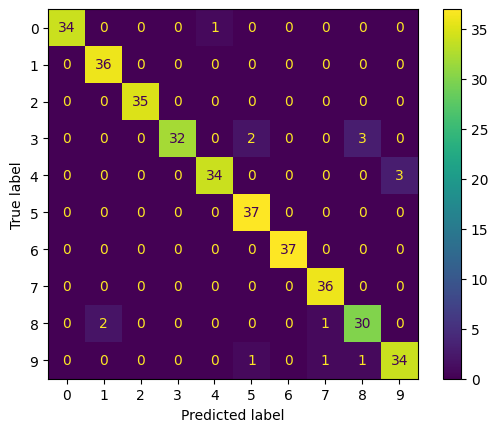

In [ ]:
## Ex 1.2 here

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)

disp.plot()
plt.show()

If everything is correct, you should notice that the diagonals contains high values: this is expected, as it means that most of the predictions are correct.
Another interesting patterns can be found are the mispredictions. There are three examples of class 4 which are predicted as class 9. Let's see how they look like. Run the following code.


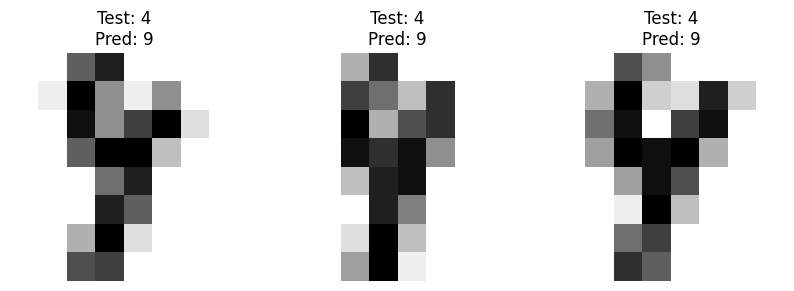

In [ ]:
indices = np.all([ (y_test==4), (y_test_pred==9) ], axis=0) # find the index of the examples of class 4 predicted as class 9
                                                            # np.all returns the elements of the input vector that satisfy all conditions
_, axes = plt.subplots(nrows=1, ncols=sum(indices==True), figsize=(10, 3))
for ax, image, label, pred_label in zip(axes, X_test[indices], y_test[indices], y_test_pred[indices]):
    ax.set_axis_off()
    ax.imshow(image.reshape(8,8), cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Test: %i\nPred: %i" % (label, pred_label))


We could argue that those seem more like 9s instead of 4s, in other words the labels are a bit noisy. As a result, we might decide not to spend time improving the performance of the algorithm, as they are not obvious errors.

These examples could be used when discussing the performance of our learning system with the clients, to show that those are mistakes that even some humans would do (of course before we need to check that the same happens for the other mistakes).

In summary, sometimes it is ok to have classifiers that do mistakes if these mistakes "make sense" somehow.


## Exercise 2: Visualising the Use of Different kernels

Recall that the SVM corresponds to a linear discriminant function in the feature space $\phi$. But how does the discriminat function look back in the input space? In this exercise, we will see how its change for different kernels and parameters. We start by creating a dataset, as usual.

Text(0.5, 1.0, 'Random Classification Data with 2 classes')

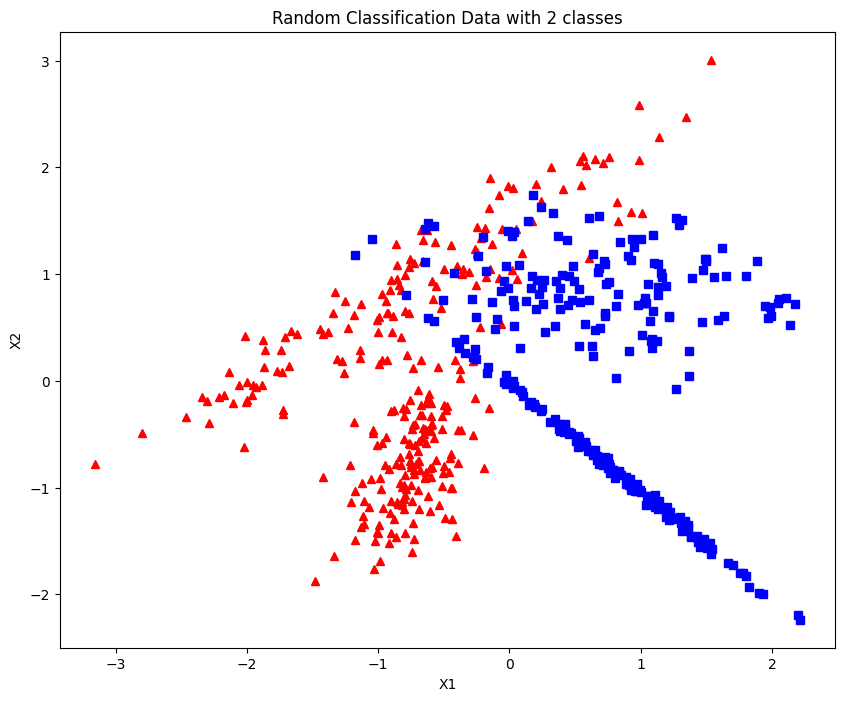

In [ ]:
#import the data
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X, y = datasets.make_classification(n_samples=700, n_features=2, random_state=124, n_redundant= 0, n_informative=2, scale=10, shift=10)
X[:, 0] = X[:, 0]*0.1

# split the data into training, and testing set.
# note: for this exercise we avoid the validation set since
# we only aim to understand how different models perform.
# we do not adopt any validation process
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, shuffle=False)

# scale
scl = StandardScaler()
scl.fit(X_train)
X_train = scl.transform(X_train)
X_test = scl.transform(X_test)


# visualize the data
fig = plt.figure(figsize=(10,8))
plt.plot(X_train[:, 0][y_train == 0], X_train[:, 1][y_train == 0], 'r^')
plt.plot(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], 'bs')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title('Random Classification Data with 2 classes')


We now create the function that, given a trained model, some data samples $X$, and the ground truth $y$, plots the model decision boundary.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


def plot_discriminat_function(X,y, trained_model):
    ## Plotting
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # h = (x_max / x_min)/100
    # xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # X_plot = np.c_[xx.ravel(), yy.ravel()]
    x_span = np.linspace(x_min, x_max, 100)
    y_span = np.linspace(y_min, y_max, 100)
    xx, yy = np.meshgrid(x_span, y_span)
    X_plot = np.c_[xx.ravel(), yy.ravel()]

    predicted = trained_model.predict(X_plot)
    predicted = predicted.reshape(xx.shape)

    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.contourf(xx, yy, predicted, alpha=0.5)
    plt.set_cmap("gist_rainbow")
    # plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'r^')
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim(xx.min(), xx.max())
    plt.title(trained_model)
    plt.show()


### Exercise 2.1

Train an SVC with:


*   kernel = 'poly'
*   degree = 2
*   coef0 = 1
*   random_state = 123

Feed the trained model into *plot_discriminat_function*, and visually analze the obtained decision boundary.



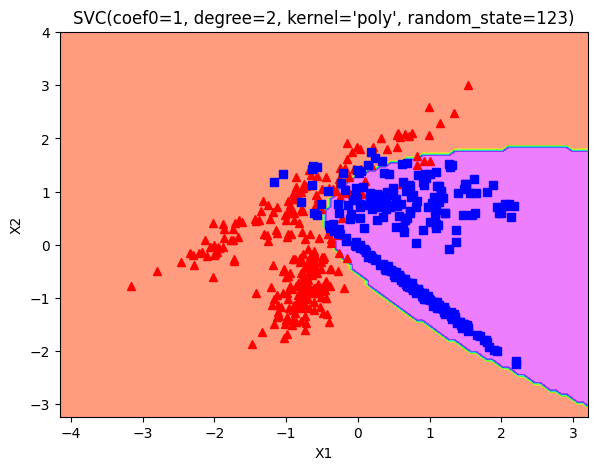

In [ ]:
# EX 2.1

#define a new SVC
svc_poly = SVC(kernel = 'poly', degree = 2, coef0 = 1, random_state = 123)

#fit over the training + validation
svc_poly.fit(X_train, y_train)

# plot
plot_discriminat_function(X_train, y_train, svc_poly)

You should notice that the discriminant function is not a line in the input space.

### Exercise 2.2

Let's define now a function that, given a trained model, computes training and testing accuracy.

Then, use this function over the model trained in Exercise 2.1 (previous step).

In [ ]:
# EX 2.2

def compute_accuracy(trained_model, X_train, y_train, X_test, y_test):
  y_train_pred = trained_model.predict(X_train)
  y_test_pred = trained_model.predict(X_test)

  train_acc = accuracy_score(y_train, y_train_pred)
  test_acc = accuracy_score(y_test, y_test_pred)
  print("Train accuracy:", train_acc)
  print("Test accuracy:", test_acc)

compute_accuracy(svc_poly, X_train, y_train, X_test, y_test)

Train accuracy: 0.9339285714285714
Test accuracy: 0.9071428571428571


### Exercise 2.3

Repeat the experiment with an SVC with linear kernel and random_state=123. Compare it with the polynomial one in terms of both accuracy (training and testing time) and discriminant function (using the plotting function).

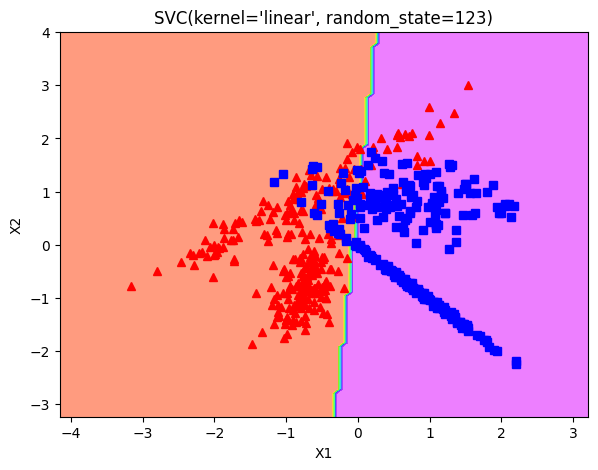

SVC with poly kernel
Train accuracy: 0.9339285714285714
Test accuracy: 0.9071428571428571

SVC with linear kernel
Train accuracy: 0.8892857142857142
Test accuracy: 0.85


In [ ]:
## EX 2.3

#SVC with linear kernel
svc_l = SVC(kernel = 'linear', random_state = 123)

#fit over the training + validation
svc_l.fit(X_train, y_train)

# plot
#plot_discriminat_function(X_train, y_train, svc)
plot_discriminat_function(X_train, y_train, svc_l)

print("SVC with poly kernel")
compute_accuracy(svc_poly, X_train, y_train, X_test, y_test)
print()
print("SVC with linear kernel")
compute_accuracy(svc_l, X_train, y_train, X_test, y_test)

### Exercise 2.4

Repeat what done in Exercise 2.3.
This time, use an RBF kernel at the varying of $\sigma$ = [0.001, 0.1, 10, 100, 500], while keeping the random_state as 123.

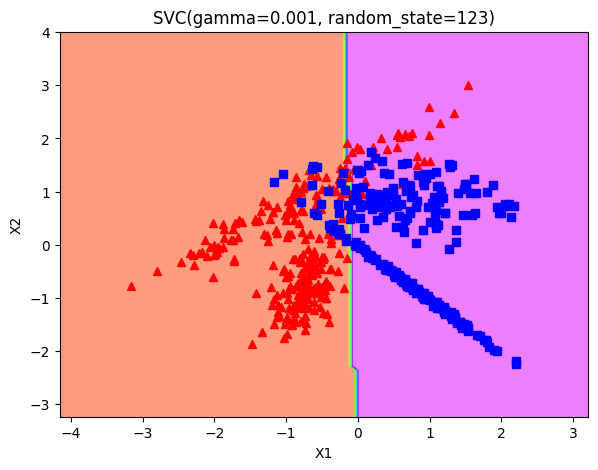

Train accuracy: 0.8910714285714286
Test accuracy: 0.85


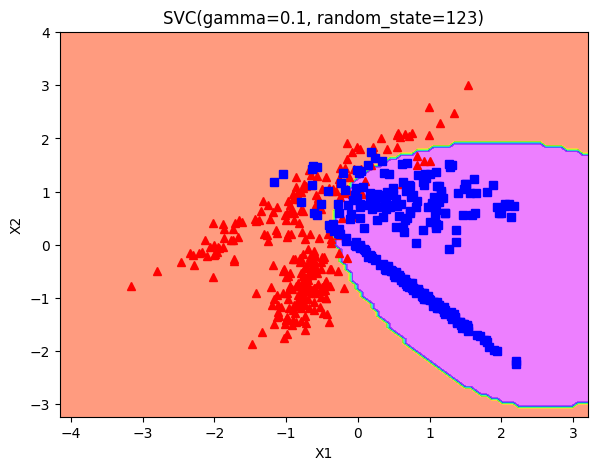

Train accuracy: 0.9267857142857143
Test accuracy: 0.8857142857142857


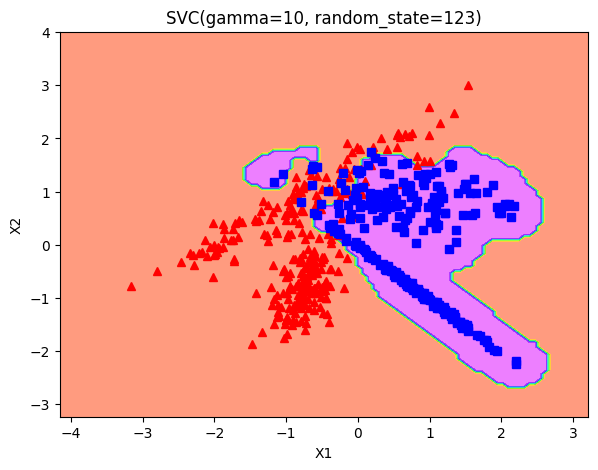

Train accuracy: 0.9535714285714286
Test accuracy: 0.8928571428571429


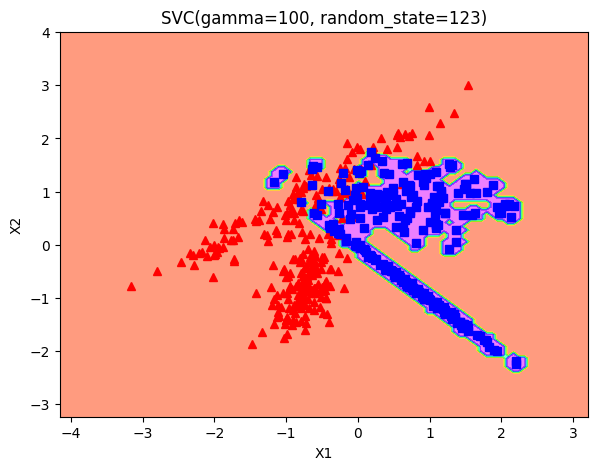

Train accuracy: 0.9732142857142857
Test accuracy: 0.8857142857142857


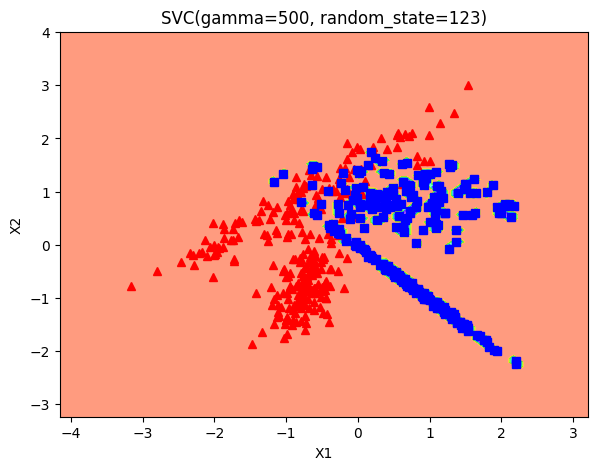

Train accuracy: 0.9892857142857143
Test accuracy: 0.7857142857142857


In [ ]:
# EX 2.4 here

for sigma in [0.001, 0.1, 10, 100, 500]:
  svc_rbf = SVC(kernel = 'rbf', gamma = sigma, random_state = 123)
  #fit over the training + validation
  svc_rbf.fit(X_train, y_train)

  # plot
  plot_discriminat_function(X_train, y_train, svc_rbf)

  # accuracy
  compute_accuracy(svc_rbf, X_train, y_train, X_test, y_test)

In [ ]:
print("SVC with poly kernel")
compute_accuracy(svc_poly, X_train, y_train, X_test, y_test)
print()
print("SVC with linear kernel")
compute_accuracy(svc_l, X_train, y_train, X_test, y_test)
print()
print("SVC with RBF kernel")
compute_accuracy(svc_rbf, X_train, y_train, X_test, y_test)

SVC with poly kernel
Train accuracy: 0.9339285714285714
Test accuracy: 0.9071428571428571

SVC with linear kernel
Train accuracy: 0.8892857142857142
Test accuracy: 0.85

SVC with RBF kernel
Train accuracy: 0.9892857142857143
Test accuracy: 0.7857142857142857


You should notice that the higher $\sigma$, the better the model over the training data.

However, the accuracy on the test set does not show the same behaviour: it improves until $\sigma=10$, and then it decreses. With high $\sigma$ values we overfit our data, meaning that the decision function tends to coincide with the training examples of the blue class (basically it's memorizing them).

## Exercise 3: Comparing the Execution Times of Learning Algorithms

In this exercise, we are going to experiment with the computational cost, i.e. training and prediction time, of different learning algorithms.

The exercise is conducted over the *MNIST* dataset. Since we will not optimising the hyperparameters of the learning algorithms, but we will use the default values, we don't have to create the validation set.

**ALERT: for this entire exercise, do not set any random_state**

In [ ]:
from sklearn.preprocessing import StandardScaler
# Split data into 80% train and 20% test subsets
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, shuffle=False)

### scale the data
scl = StandardScaler().fit(X_train)
X_train_scl = scl.transform(X_train)
X_test_scl = scl.transform(X_test)

num_classes = len(set(y_train))
num_features = X_train.shape[1]

print(f"train size={len(X_train_scl)}, test size={len(X_test_scl)}")
print(f"number of features = {num_features}; number of classes = {num_classes}")

train size=1437, test size=360
number of features = 64; number of classes = 10


### Exercise 3.1: Function for Collecting Stats on Execution Time and Accuracy

Create a function that, given a learning algorithm implemented in Sklearn: 1) trains it on the training set; 2) computes the predictions over training and test sets.
The function must keep track of the time needed to do training, that needed to make predictions and the accuracies on the training and test sets.

Such values should be defined as the average over 5 executions.
More precisely, the results should be added to the following lists:

1.   tr_time_list = list containing the training time of a specific model.
2.   te_time_list = list containing the testing time of a specific model; this execution time contains the prediction on both train and test splits.
3.   tr_acc_list = list containing the training accuracy of a specific model.
4.   te_acc_list = list containing the accuracy on the test set of a specific model.
5.   model_name_list = list containing the model name.

Complete the code below that implements the function described in this box.

In [ ]:
## Ex 3.1
from sklearn.linear_model import Perceptron

def test_algorithm(learning_alg, X_train, y_train, X_test, y_test):

  #empty list to keep track of the running times and accuracy values of each repetition
  train_time, test_time, train_accuracy, test_accuracy = [], [], [], []

  #
  # ADD YOUR CODE HERE
  #

  repetitions = 5

  for _ in range(repetitions):
    # 1) trains it on the training set
    start_time = time.time()
    learning_alg.fit(X_train, y_train)
    end_time = time.time()
    delta = end_time - start_time
    train_time.append(delta)

    # 2) computes the predictions over training and test sets
    start_time = time.time()
    y_train_pred = learning_alg.predict(X_train)
    y_test_pred = learning_alg.predict(X_test)
    end_time = time.time()
    delta = end_time - start_time
    test_time.append(delta)

    # 3) train accuracy
    train_acc_score = accuracy_score(y_train, y_train_pred)
    train_accuracy.append(train_acc_score)

    # 4) test accuracy
    test_acc_score = accuracy_score(y_test, y_test_pred)
    test_accuracy.append(test_acc_score)

  #
  # END OF MY CODE
  #

  #the function need to return all the stats computed. The following line of code does that
  return np.mean(train_time), np.mean(test_time), np.mean(train_accuracy), np.mean(test_accuracy)

# You can test your function by invoking it as follows
clf = Perceptron()
tr_time, te_time, tr_acc, te_acc = test_algorithm(clf, X_train_scl,y_train, X_test_scl, y_test)
print(f"Perceptron\n   Training time: {tr_time}\n   Prediction time: {te_time}")
print(f"   Accuracy on train: {tr_acc}\n   Accuracy on test: {te_acc}")

Perceptron
   Training time: 0.1757046699523926
   Prediction time: 0.012515974044799805
   Accuracy on train: 0.9832985386221293
   Accuracy on test: 0.8916666666666668


### Exercise 3.2

Now use the function test_algorithm() implemented in the previous exercise to collect statistics for the following models:

1. Perceptron
2. Logistic Regression
3. SVM with linear kernel
4. SVM with polynomial kernel of degree 2
5. SVM with polynomial kernel of degree 3
6. Decision Tree using Entropy for splitting
7. K-NN with K=3

The final statistics must be collected in the following lists: tr_time_list, te_time_list, tr_acc_list, te_acc_list, model_name_list, which are defined in the previuos exercise.

In order to reduce your waiting time, you might want to use more than one cell, even one per algorithm.

In [ ]:
# EX 1.2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

#initialize the lists collecting the stats
tr_time_list, te_time_list, tr_acc_list, te_acc_list, model_name_list = [], [], [], [], []

## ADD YOUR CODE HERE THAT INVOKES test_algorithm() and collects the statistics in the lists above

In [ ]:
# 1) Perceptron
model_name_list.append("Perceptron")
tr_time, te_time, tr_acc, te_acc = test_algorithm(Perceptron(), X_train_scl,y_train, X_test_scl, y_test)
tr_time_list.append(tr_time)
te_time_list.append(te_time)
tr_acc_list.append(tr_acc)
te_acc_list.append(te_acc)

print(f"Perceptron\n   Training time: {tr_time}\n   Prediction time: {te_time}")
print(f"   Accuracy on train: {tr_acc}\n   Accuracy on test: {te_acc}")
print()


# 2) Logistic Regression
model_name_list.append("LigisticRegression")
tr_time, te_time, tr_acc, te_acc = test_algorithm(LogisticRegression(), X_train_scl,y_train, X_test_scl, y_test)
tr_time_list.append(tr_time)
te_time_list.append(te_time)
tr_acc_list.append(tr_acc)
te_acc_list.append(te_acc)

print(f"Logistic Regression\n   Training time: {tr_time}\n   Prediction time: {te_time}")
print(f"   Accuracy on train: {tr_acc}\n   Accuracy on test: {te_acc}")
print()

Perceptron
   Training time: 0.20494456291198732
   Prediction time: 0.012239742279052734
   Accuracy on train: 0.9832985386221293
   Accuracy on test: 0.8916666666666668

Logistic Regression
   Training time: 0.7923414230346679
   Prediction time: 0.00502324104309082
   Accuracy on train: 1.0
   Accuracy on test: 0.8972222222222224



In [ ]:
# 3) SVM with linear kernel
model_name_list.append("SVM_linear")
tr_time, te_time, tr_acc, te_acc = test_algorithm(SVC(kernel = 'linear'), X_train_scl,y_train, X_test_scl, y_test)
tr_time_list.append(tr_time)
te_time_list.append(te_time)
tr_acc_list.append(tr_acc)
te_acc_list.append(te_acc)

print(f"SVM with linear kernel\n   Training time: {tr_time}\n   Prediction time: {te_time}")
print(f"   Accuracy on train: {tr_acc}\n   Accuracy on test: {te_acc}")
print()

# 4) SVM with polynomial kernel of degree 2
model_name_list.append("SVM_poly_2")
tr_time, te_time, tr_acc, te_acc = test_algorithm(SVC(kernel = 'poly', degree = 2), X_train_scl,y_train, X_test_scl, y_test)
tr_time_list.append(tr_time)
te_time_list.append(te_time)
tr_acc_list.append(tr_acc)
te_acc_list.append(te_acc)

print(f"SVM with polynomial kernel of degree 2\n   Training time: {tr_time}\n   Prediction time: {te_time}")
print(f"   Accuracy on train: {tr_acc}\n   Accuracy on test: {te_acc}")
print()

# 5) SVM with polynomial kernel of degree 3
model_name_list.append("SVM_poly_3")
tr_time, te_time, tr_acc, te_acc = test_algorithm(SVC(kernel = 'poly', degree = 3), X_train_scl,y_train, X_test_scl, y_test)
tr_time_list.append(tr_time)
te_time_list.append(te_time)
tr_acc_list.append(tr_acc)
te_acc_list.append(te_acc)

print(f"SVM with polynomial kernel of degree 3\n   Training time: {tr_time}\n   Prediction time: {te_time}")
print(f"   Accuracy on train: {tr_acc}\n   Accuracy on test: {te_acc}")
print()

SVM with linear kernel
   Training time: 0.07142372131347656
   Prediction time: 0.06021566390991211
   Accuracy on train: 1.0
   Accuracy on test: 0.9277777777777778

SVM with polynomial kernel of degree 2
   Training time: 0.1848367214202881
   Prediction time: 0.15707869529724122
   Accuracy on train: 0.9958246346555324
   Accuracy on test: 0.9416666666666667

SVM with polynomial kernel of degree 3
   Training time: 0.20166873931884766
   Prediction time: 0.1765073776245117
   Accuracy on train: 0.9846903270702854
   Accuracy on test: 0.9027777777777779



In [ ]:
# 6) Decision Tree using Entropy for splitting
model_name_list.append("Decision_Tree")
tr_time, te_time, tr_acc, te_acc = test_algorithm(tree.DecisionTreeClassifier(criterion = 'entropy'), X_train_scl,y_train, X_test_scl, y_test)
tr_time_list.append(tr_time)
te_time_list.append(te_time)
tr_acc_list.append(tr_acc)
te_acc_list.append(te_acc)

print(f"Decision Tree\n   Training time: {tr_time}\n   Prediction time: {te_time}")
print(f"   Accuracy on train: {tr_acc}\n   Accuracy on test: {te_acc}")
print()

# 7) K-NN with K=3
model_name_list.append("K-nn")
tr_time, te_time, tr_acc, te_acc = test_algorithm(KNeighborsClassifier(n_neighbors=3), X_train_scl,y_train, X_test_scl, y_test)
tr_time_list.append(tr_time)
te_time_list.append(te_time)
tr_acc_list.append(tr_acc)
te_acc_list.append(te_acc)

print(f"Decision Tree\n   Training time: {tr_time}\n   Prediction time: {te_time}")
print(f"   Accuracy on train: {tr_acc}\n   Accuracy on test: {te_acc}")
print()

Decision Tree
   Training time: 0.031081485748291015
   Prediction time: 0.0013031959533691406
   Accuracy on train: 1.0
   Accuracy on test: 0.7866666666666667

Decision Tree
   Training time: 0.0011758804321289062
   Prediction time: 0.5010648250579834
   Accuracy on train: 0.9895615866388308
   Accuracy on test: 0.9416666666666667



In [ ]:
for i in range(len(tr_time_list)):
  print(f"{model_name_list[i]}\n   Training time: {tr_time_list[i]}\n   Prediction time: {te_time_list[i]}")
  print(f"   Accuracy on train: {tr_acc_list[i]}\n   Accuracy on test {te_acc_list[i]}")

Perceptron
   Training time: 0.20494456291198732
   Prediction time: 0.012239742279052734
   Accuracy on train: 0.9832985386221293
   Accuracy on test 0.8916666666666668
LigisticRegression
   Training time: 0.7923414230346679
   Prediction time: 0.00502324104309082
   Accuracy on train: 1.0
   Accuracy on test 0.8972222222222224
SVM_linear
   Training time: 0.07142372131347656
   Prediction time: 0.06021566390991211
   Accuracy on train: 1.0
   Accuracy on test 0.9277777777777778
SVM_poly_2
   Training time: 0.1848367214202881
   Prediction time: 0.15707869529724122
   Accuracy on train: 0.9958246346555324
   Accuracy on test 0.9416666666666667
SVM_poly_3
   Training time: 0.20166873931884766
   Prediction time: 0.1765073776245117
   Accuracy on train: 0.9846903270702854
   Accuracy on test 0.9027777777777779
Decision_Tree
   Training time: 0.031081485748291015
   Prediction time: 0.0013031959533691406
   Accuracy on train: 1.0
   Accuracy on test 0.7866666666666667
K-nn
   Training ti

In [ ]:
print(tr_time_list, te_time_list, tr_acc_list, te_acc_list, model_name_list)

[0.20494456291198732, 0.7923414230346679, 0.07142372131347656, 0.1848367214202881, 0.20166873931884766, 0.031081485748291015, 0.0011758804321289062] [0.012239742279052734, 0.00502324104309082, 0.06021566390991211, 0.15707869529724122, 0.1765073776245117, 0.0013031959533691406, 0.5010648250579834] [0.9832985386221293, 1.0, 1.0, 0.9958246346555324, 0.9846903270702854, 1.0, 0.9895615866388308] [0.8916666666666668, 0.8972222222222224, 0.9277777777777778, 0.9416666666666667, 0.9027777777777779, 0.7866666666666667, 0.9416666666666667] ['Perceptron', 'LigisticRegression', 'SVM_linear', 'SVM_poly_2', 'SVM_poly_3', 'Decision_Tree', 'K-nn']


### Visualising the Results

We can now visualise the results obtained. Remember that here, each of the five lists must contain 7 values. Double check it: if you have more, you might have re-executed a cell multiple times. If so, just re-execute the entire notebook.

In [ ]:
#this cell checks if you have the right amount of info
expected_list_length = 7
assert len(tr_acc_list) == expected_list_length
assert len(te_acc_list) == expected_list_length
assert len(tr_time_list) == expected_list_length
assert len(te_time_list) == expected_list_length
assert len(model_name_list) == expected_list_length

Text(0, 0.5, 'Training Time [s]')

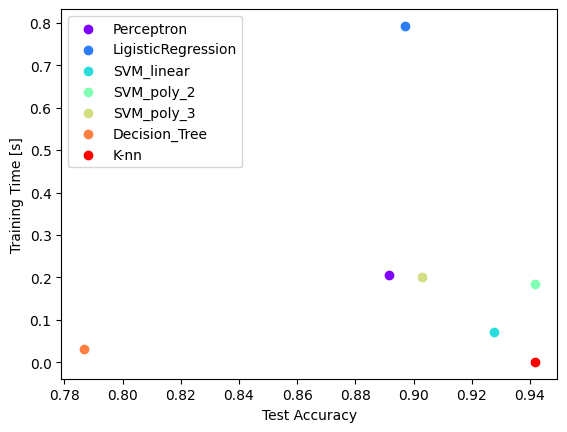

In [ ]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(model_name_list)))
for x, y, c, m in zip(te_acc_list, tr_time_list, colors, model_name_list):
    plt.scatter(x, y, color = c, label = m)
plt.legend()
plt.xlabel("Test Accuracy")
plt.ylabel("Training Time [s]")


Text(0, 0.5, 'Prediction Time [s]')

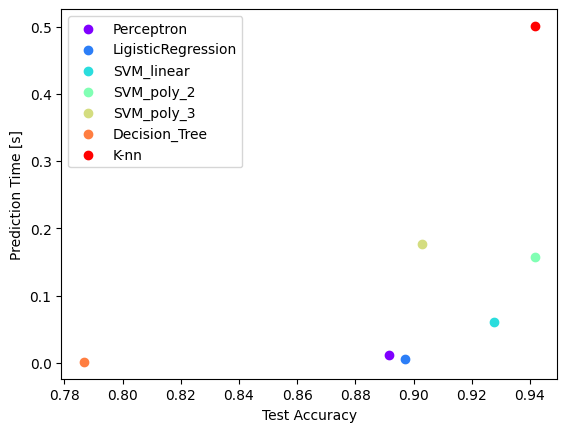

In [ ]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(model_name_list)))
for x, y, c, m in zip(te_acc_list, te_time_list, colors, model_name_list):
    plt.scatter(x, y, color = c, label = m)
plt.legend()
plt.xlabel("Test Accuracy")
plt.ylabel("Prediction Time [s]")


# Ex 3.3

In this new exercise, it's time to be more independent from us. \
Try and get good performances on the *wine_dataset*.

Remember: use the testing set only *at the end*, after you selected the best model.


In [ ]:
from sklearn.datasets import load_wine #load our target dataset

#load the dataset
dataset = load_wine()

#extract X and y
X = dataset.data
y = dataset.target

#split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size = 0.8, random_state = 123)